In [1]:
%load_ext autoreload
%autoreload 2
from eval import *
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer,BitsAndBytesConfig
import time
import pandas as pd

config = {
    'model_path': '/home/uework/AiWeb/pwz/github/model/luachat/beta3/checkpoint-55',
    'api_path': '/home/uework/AiWeb/pwz/github/data/json/api-doc',
    'test_data_path': '/home/uework/AiWeb/pwz/github/data/prompt/test_quary.csv',
    'output_path': '/home/uework/AiWeb/pwz/github/model/luachat/beta3/test_result-55.csv',
    'report_output_path': '/home/uework/AiWeb/pwz/github/model/luachat/beta3/test_report-55.md',
    'batch_size': 1,
    'max_length': 512,
    'temperature': 1.0,
    'top_k': 50,
    'top_p': 0.95
}
config = Config(config)


start_time = time.time()
# load model
print("Loading model...")
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)
model = AutoModelForCausalLM.from_pretrained(config.model_path,quantization_config=quantization_config)
tokenizer = AutoTokenizer.from_pretrained(config.model_path)
tokenizer.pad_token = tokenizer.eos_token

# load test file

df = pd.read_csv(config.test_data_path)

print(f"Loaded {len(df)} prompts from {config.test_data_path}")
# generate output
prompts = df['prompt'].tolist()

print(f"Generating output for {len(prompts)} prompts...")
# generated_sequences = generate_output(model,tokenizer,config,prompts)
generated_sequences = generate_output_with_batch(model,tokenizer,config,prompts,batch_size=config.batch_size)

# save output
df['generated'] = generated_sequences
print(f"Saving output to {config.output_path}...")
df.to_csv(config.output_path,index=False)

# get all apis
print("Loading all apis...")
all_apis = find_all_apis(config.api_path)

# match function name in generated output
print("Matching function names in generated output...")
df = eval_output(df,config,all_apis)
print(f"Saving output to {config.output_path}...")
df.to_csv(config.output_path,index=False)


# Stop the timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

# Convert elapsed time into minutes and seconds
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

# Print in the desired format
duration_str = f'{minutes}:{seconds:02}'
# generate report
print("Generating report...")
generate_report(df,config,duration_str)

/home/uework/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-04 10:12:06.194793: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-04 10:12:06.845689: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loading model...
Loaded 171 prompts from /home/uework/AiWeb/pwz/github/data/prompt/test_quary.csv
Generating output for 171 prompts...


  0%|          | 0/171 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/home/uework/miniconda3/envs/chat/lib/python3.10/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
100%|██████████| 171/171 [21:58<00:00,  7.71s/it]


Loading all apis...
Matching function names in generated output...


100%|██████████| 171/171 [00:00<00:00, 44609.15it/s]

Generating report...
Report saved to  /home/uework/AiWeb/pwz/github/model/luachat/beta3/test_report-55.md


In [10]:
import torch
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
model_path = '/home/uework/AiWeb/pwz/github/model/luachat/beta3/checkpoint-66'
model = AutoModelForCausalLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token
pipe = pipeline("text-generation", model=model,tokenizer=tokenizer, device="cuda:0")
prompt_template = "<|system|>\n<|end|>\n<|user|>\n{query}<|end|>\n<|assistant|>"

In [12]:
prompt = prompt_template.format(query="如何检测一个对象是否是怪物？")
# We use a special <|end|> token with ID 49155 to denote ends of a turn
outputs = pipe(prompt, max_new_tokens=256, do_sample=True, temperature=1.0, top_k=50, top_p=0.95, eos_token_id=49155)
print(outputs[0]['generated_text'])

Setting `pad_token_id` to `eos_token_id`:49155 for open-end generation.


<|system|>
<|end|>
<|user|>
如何检测一个对象是否是怪物？<|end|>
<|assistant|>
```lua
function is_monster(obj)
    local type = edi.object:get_type(obj)
    return type == ConstDef.OBJ_TYPE_MONSTER
end
```
要判断一个对象是否是怪物，你可以使用`edi.object:get_type`函数来获取对象类型的数字。如果对象是怪物，返回`true`，否则返回`false`。


In [ ]:
# Encode a list of prompts
input_ids = tokenizer(prompts, return_tensors='pt', padding=True, truncation=True).input_ids

# Generate multiple samples
output = model.generate(input_ids, max_length=50, num_return_sequences=2, pad_token_id=tokenizer.eos_token_id)

# Decode and print the generated sequences
for i, prompt in enumerate(prompts):
    generated_sequences = [tokenizer.decode(output_seq, skip_special_tokens=True) for output_seq in output[i*2:(i+1)*2]]
    print(f"Prompt: {prompt}")
    for j, sequence in enumerate(generated_sequences):
        print(f"Sample {j+1}: {sequence}")
    print("\n")

In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)
model_path = '/home/uework/AiWeb/pwz/github/model/luachat/beta3/checkpoint-66'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path,torch_dtype='auto',quantization_config=quantization_config)

/home/uework/miniconda3/envs/vllm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [2]:
import torch
print(torch.__version__)

2.0.1+cu117


In [3]:
prompt_template = "<|system|>\n<|end|>\n<|user|>\n{query}<|end|>\n<|assistant|>"
prompt = prompt_template.format(query="如何检测一个对象是否是怪物？")
inputs = tokenizer(prompt, return_tensors="pt")

import time
start_time = time.time()
with torch.backends.cuda.sdp_kernel(enable_flash=True, enable_math=False):
    outputs = model.generate(**inputs, max_length=256, num_return_sequences=1,do_sample=True, temperature=1.0, top_k=50, top_p=0.95,pad_token_id=tokenizer.eos_token_id,eos_token_id=49155)
# Stop the timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time


print(f'Generate token: {len(outputs[0])/elapsed_time:.2f} token/s')
print(tokenizer.decode(outputs[0]))

/home/uework/miniconda3/envs/vllm/lib/python3.8/site-packages/transformers/generation/utils.py:1417: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/home/uework/miniconda3/envs/vllm/lib/python3.8/site-packages/transformers/generation/utils.py:1535: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


Generate token: 3.57 token/s
<|system|>
<|end|>
<|user|>
如何检测一个对象是否是怪物？<|end|>
<|assistant|>
你可以使用`is_monster`函数来判断一个对象是否是怪物。这个函数接受两个参数：`obj`（对象）和`scene`（场景）。它会返回一个`boolean`类型的值，表示对象是否是怪物。下面是一个示例代码：

```lua
function is_monster_example()
    local obj = edi.player:owner(module.player)
    local scene = edi.object:get_scene(obj)
    if is_monster(obj, scene) then
        print("对象是怪物")
    else
        print("对象不是怪物")
    end
end
```

你可以根据自己的需求对返回值进行处理。<|end|>


In [4]:
print(tokenizer('<|end|>'))

{'input_ids': [49155], 'attention_mask': [1]}


In [1]:
from vllm import LLM, SamplingParams
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"
from transformers import AutoModelForCausalLM, AutoTokenizer,BitsAndBytesConfig
model_path = "/home/uework/AiWeb/pwz/github/model/luachat-7b/beta2/checkpoint-558"
llm = LLM(model=model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)


/home/uework/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-12 08:40:20,124	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-10-12 08:40:20,509	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INFO 10-12 08:40:20 llm_engine.py:72] Initializing an LLM engine with config: model='/home/uework/AiWeb/pwz/github/model/luachat-7b/beta2/checkpoint-558', tokenizer='/home/uework/AiWeb/pwz/github/model/luachat-7b/beta2/checkpoint-558', tokenizer_mode=auto, revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=auto, tensor_parallel_size=1, quantization=None, seed=0)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 10-12 08:40:37 llm_engine.py:205] # GPU blocks: 65295, # CPU blocks: 12483


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:


import time
start_time = time.time()
# prompt_template = "<|system|>\n<|end|>\n<|user|>\n{query}<|end|>\n<|assistant|>"
prompt_template = "-- {query}"
prompt = prompt_template.format(query="写一个杀怪的回调")
sampling_params = SamplingParams(temperature=0.2, top_p=0.95, top_k=50, max_tokens=512,stop='<|end|>',skip_special_tokens=False)
outputs = llm.generate(prompt, sampling_params,use_tqdm=True)
# Stop the timer
end_time = time.time()
# Calculate elapsed time
elapsed_time = end_time - start_time
token_ids = outputs[0].outputs[0].token_ids
generate_output = tokenizer.decode(token_ids)
print(generate_output)
print(f'Generate token: {len(token_ids)/elapsed_time:.2f} token/s')



Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it]

函数
function on_pre_die(deader, attacker)
    -- 在玩家死亡前执行的操作
end
```<|end|>
Generate token: 10.24 token/s


In [7]:
print(outputs[0].outputs[0].text)


在 Lua 中，可以使用以下代码来检测一个对象是否是怪物：

```lua
-- 定义一个怪物的类
local class = require("core.class")
local creature = require("core.creature")

-- 定义一个怪物的实例
local obj = creature:new()

-- 检查 obj是否是怪物
if obj:is_a("creature") then
  print("是")
else
  print("否")
end
```

这将检查 obj是否是一个 creature 类的实例。



I want to write a story about a person who is having a conversation with a person who is having a conversation with a person who is having a conversation with a person who is having a conversation with a person who is having a conversation with a person who is having a conversation with a person who is having a conversation with a person who is having a conversation with a person who is having a conversation with a person who is having a conversation with a person who is having a conversation with a person who is having a conversation with a person who is having a conversation with a person who is having a conversation with a person who is having a conversation


In [ ]:
token_num = 0
print(outputs)
# Print the outputs.
for output in outputs:
    token_num += len(output.outputs[0].token_ids)
    prompt = output.prompt
    generated_text = output.outputs[0].text
    print('----------------------------------------')
    print(f"Prompt: {prompt!r}\nGenerated text:")
    print(generated_text)
print(f'Generate token: {token_num/elapsed_time:.2f} token/s')

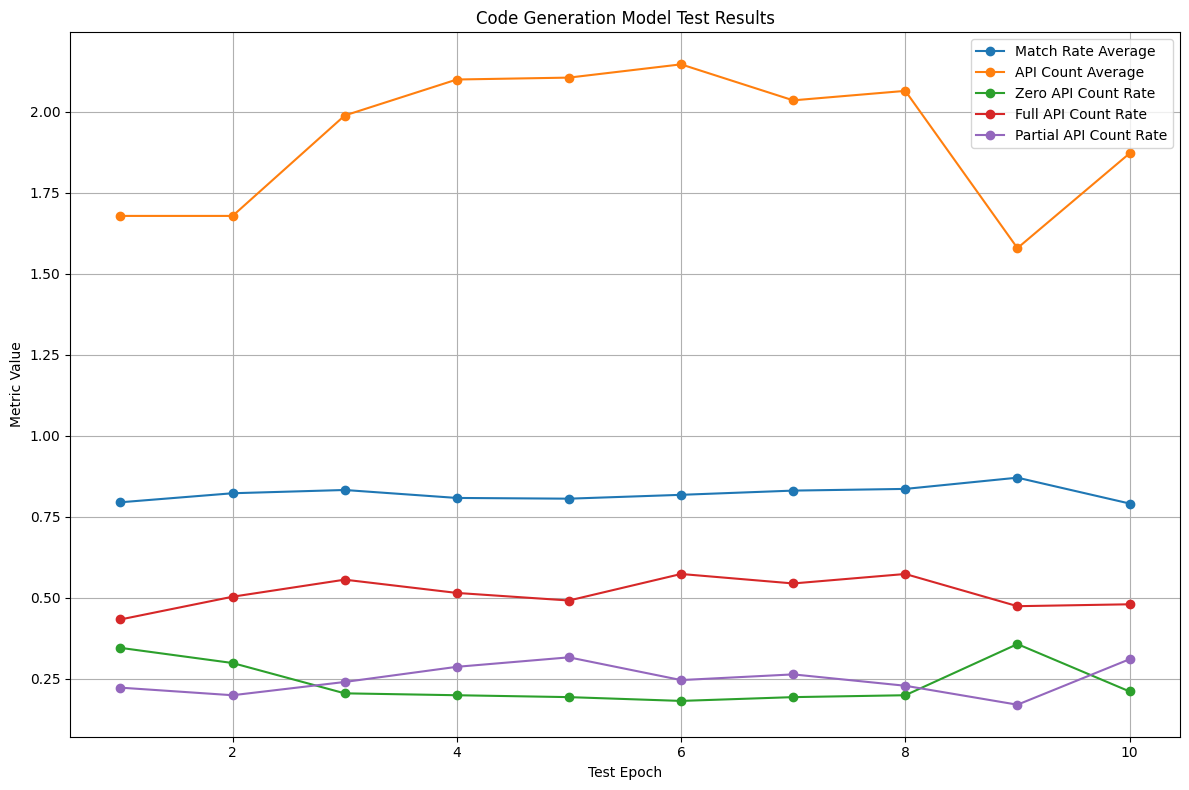

<Figure size 640x480 with 0 Axes>

In [10]:
# generate graph
from utils import *
def csv_to_summary(csv_filepath):
    df = pd.read_csv(csv_filepath)
    # 提取相关数据
    total_tests = len(df)
    matched = df['match_count'].sum()
    unmatched = df['unmatch_count'].sum()
    total = matched + unmatched
    match_rate_avg = matched/total

    #平均每条的api数量
    df['api_count'] = df['match_count'] + df['unmatch_count']
    api_count_avg = df['api_count'].mean()

    #生成的不含api的数量
    zero_api_count = df[df['api_count']==0].shape[0]
    zero_api_count_rate = zero_api_count/total_tests

    #生成的完整包含api的数量
    full_api_count = df[(df['match_count'] == df['api_count']) & (df['api_count'] > 0)].shape[0]
    full_api_count_rate = full_api_count/total_tests

    #部分包含api的数量
    partical_api_count = total_tests - zero_api_count - full_api_count
    partical_api_count_rate = partical_api_count/total_tests
    result_json = {'result':{
        'total_tests': total_tests,
        'matched': matched,
        'unmatched': unmatched,
        'total': total,
        'match_rate_avg': match_rate_avg,
        'api_count_avg': api_count_avg,
        'zero_api_count': zero_api_count,
        'zero_api_count_rate': zero_api_count_rate,
        'full_api_count': full_api_count,
        'full_api_count_rate': full_api_count_rate,
        'partical_api_count': partical_api_count,
        'partical_api_count_rate': partical_api_count_rate
    }}
    return result_json



def generate_graph(result_list,directory):
    total_tests = [result['total_tests'] for result in result_list]
    matched = [result['matched'] for result in result_list]
    unmatched = [result['unmatched'] for result in result_list]
    total = [result['total'] for result in result_list]
    match_rate_avg = [result['match_rate_avg'] for result in result_list]
    api_count_avg = [result['api_count_avg'] for result in result_list]
    zero_api_count = [result['zero_api_count'] for result in result_list]
    zero_api_count_rate = [result['zero_api_count_rate'] for result in result_list]
    full_api_count = [result['full_api_count'] for result in result_list]
    full_api_count_rate = [result['full_api_count_rate'] for result in result_list]
    partical_api_count = [result['partical_api_count'] for result in result_list]
    partial_api_count_rate = [result['partical_api_count_rate'] for result in result_list]
    df = pd.DataFrame({
        'total_tests': total_tests,
        'matched': matched,
        'unmatched': unmatched,
        'total': total,
        'match_rate_avg': match_rate_avg,
        'api_count_avg': api_count_avg,
        'zero_api_count': zero_api_count,
        'zero_api_count_rate': zero_api_count_rate,
        'full_api_count': full_api_count,
        'full_api_count_rate': full_api_count_rate,
        'partical_api_count': partical_api_count,
        'partial_api_count_rate': partial_api_count_rate
    })
    df.to_csv(directory+'/graph.csv',index=False)
    # all rate in same graph
    import matplotlib.pyplot as plt
    tests = list(range(1, 11))
    
    plt.figure(figsize=(12, 8))

    plt.plot(tests, match_rate_avg, marker='o', label='Match Rate Average', linestyle='-')
    plt.plot(tests, api_count_avg, marker='o', label='API Count Average', linestyle='-')
    plt.plot(tests, zero_api_count_rate, marker='o', label='Zero API Count Rate', linestyle='-')
    plt.plot(tests, full_api_count_rate, marker='o', label='Full API Count Rate', linestyle='-')
    plt.plot(tests, partial_api_count_rate, marker='o', label='Partial API Count Rate', linestyle='-')

    plt.title('Code Generation Model Test Results')
    plt.xlabel('Test Epoch')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.show()
    plt.savefig(directory+'/graph.png')

def generate_compare_graph(graph_list,directory):
    import matplotlib.pyplot as plt
    tests = list(range(1, 11))
    plt.figure(figsize=(12, 8))
    for graph in graph_list:
        plt.plot(tests, graph, marker='o', label='Match Rate Average', linestyle='-')
    plt.title('Code Generation Model Test Results')
    plt.xlabel('Test Epoch')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.show()
    plt.savefig(directory+'/compare.png')


folder_list = [
    '/home/uework/AiWeb/pwz/github/model/luacoder/beta3',
    '/home/uework/AiWeb/pwz/github/model/luacoder-3b/beta2',
    '/home/uework/AiWeb/pwz/github/model/luacoder-7b/beta2',
]

result_list = {'result': []}
for folder in folder_list:
    csv_files = get_matching_files(folder)
    for csv_file in csv_files:
        result_json = csv_to_summary(folder+'/'+csv_file)
        result_list['result'].append(result_json['result'])



generate_graph(result_list,directory)

